In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from dateutil import parser
from itertools import repeat
from collections import Counter, OrderedDict
import random

March Madness. The Big Dance. 35 years of a 64 team basketball tournament and only one, _one_ [lonely bracket](https://www.si.com/college-basketball/2019/03/26/march-madness-ncaa-tournament-perfect-bracket-greg-nigl) has ever verifiably remained perfect through
the first two rounds. Each year a 10 member selection committee decides which 64 teams will make the tournament and rank orders
them based on regular season and conference tournament performance. This rank ordering system is known as "seeding," and seeds
are distributed from 1-16 across four regions of 16 teams. After selection Sunday, the regions and seeds are revealed to the public, with the first games taking place roughly 3-4 days later. There are entire analytics teams
dedicated to predicting the outcomes of the 63 game tournament, but with little success. In 35 years there has been just one 
bracket to ever verifiably remain perfect throughout the first 48 games. Many articles exist outling advanced machine learning
techniques to manipulate the data, engineer features that are likely to be predictive of success, and train predictive models
to forecast the results of each game. Clearly though, these methods can only take you so far, and for the average sports fan,
are largely unattainable. It turns out that there are a fair amount of insights to be gathered from looking only at the seeding
system, in particular, at upset rates and expected seed distributions. I used much of this analysis when filling out my 2019
bracket and, to my surprise, clinched 1st place in a 60+ person pool, as well as 2nd place in a 100+ person pool. Of course, there is 
absolutlely no guarantee that any of these methods will carry repeat success, but I'm going to share my results anyway. Take it
or leave it but whatever you do, don't forget to practice your [free throws](https://twitter.com/marchmadness/status/1114682787703877633?lang=en)

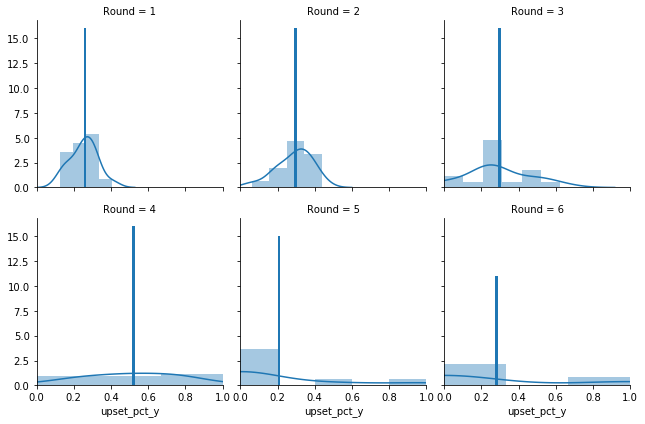

In [173]:
# apologies for the ugly data manipulation, im new to pandas
data = pd.read_csv('ncaa_data.csv')
data['winning_seed'] = np.where(data['score_1']>=data['score_2'], data['seed_1'], data['seed_2'])
data = data.drop(['Region Number', 'Region Name'], axis=1)
data['favorite'] = np.where(data['seed_1']<data['seed_2'], data['seed_1'], data['seed_2'])
data['underdog'] = np.where(data['seed_1']<data['seed_2'], data['seed_2'], data['seed_1'])
data['favorite'] = np.where(data['seed_1'] == data['seed_2'], -1, data['favorite'])
data['underdog'] = np.where(data['seed_1'] == data['seed_2'], -1, data['underdog'])
data['upset'] = np.where(data['winning_seed'] != data['favorite'], 1, 0)
data['upset'] = np.where(data['favorite'] == -1, 0, data['upset'])
data = data.query('Year >= 2003')
all_potentially_upset_games = data.query('favorite != -1')[['upset', 'Round', 'Year']].groupby(['Round', 'Year']).agg('count')
all_upsets = data[['upset', 'Round', 'Year']].groupby(['Round', 'Year']).agg('sum')
upset_pct = pd.concat([all_potentially_upset_games, all_upsets], axis=1, ignore_index=True)
upset_pct = upset_pct.rename(columns = {0: "upset_candidates", 
                                 1:"actual_upsets" 
                                 })
upset_pct['upset_pct'] = upset_pct['actual_upsets']/upset_pct['upset_candidates']
upset_pct = upset_pct.reset_index()
upset_pct = upset_pct.query('upset_candidates > 0')
means = upset_pct[['upset_pct', 'Round']].groupby('Round').agg('mean').reset_index()
trial = upset_pct.merge(means, on='Round', how='left')
g = sn.FacetGrid(trial, col="Round", col_wrap=3)
g = g.map(sn.distplot, "upset_pct_x")
g = g.map(plt.hist, 'upset_pct_y', bins=70)
g.set(xlim=(0,1))

Takeaway #1: One of my first interesting findings was the fact that upsets are almost _twice as likely_ to occur during the elite compared
to other rounds of the tournament. Considering games where an upset was possible _(ie seed1 != seed2)_ as upset candidates, and
counting the number of actual upsets that occured, I graphed the distribution of upset percentages for each round over the
16 year period. Interestingly the rate was pretty stable around 25% _except in the elite eight_. The round 4 upset average
was over 50% ! If you're not sure where to pick out some upsets for your bracket, the elite eight isn't a bad place to start.

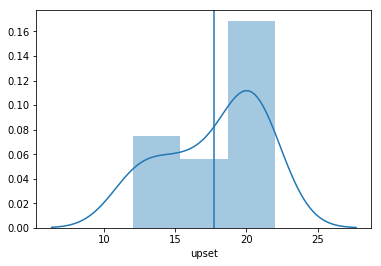

In [174]:
yearly_upset_counts = data.query('Year >= 2003 & favorite != -1')[['upset', 'Year']].groupby(['Year']).agg('sum')['upset']
sn.distplot(yearly_upset_counts)
plt.axvline(yearly_upset_counts.agg('mean'))

Takewaay #2: There are an average of about 18 upsets per tournament. The distribution looks somewhat bimodal. Roughly speaking though, you should try to have between 15 and 20 upsets in your bracket

Text(0.5, 1.0, 'Upsetters: The Avengers')

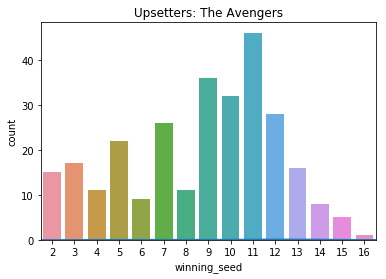

In [175]:
upsetters = data.query('upset == 1')[['winning_seed', 'Round']]
sn.distplot(upsetters['winning_seed'])
upsetters['winning_seed'].value_counts()
sn.countplot(x=upsetters['winning_seed']).set_title('Upsetters: The Avengers')

Takeaway #3: 11 seeds commit the most upsets out of all seeds in the tournament. 9, 10, and 12 seeds are next most likely to
emerge victorious over a more favorably seeded opponent. Until last year, no 16 seed had ever committed an upset, until UMBC. 
Thanks for making this plot symmetrical, [Retrievers](https://www.youtube.com/watch?v=pIoVgJTOx5Y).

Text(0.5, 1.0, 'Upsettees: The _Not_ Cindarella Stories')

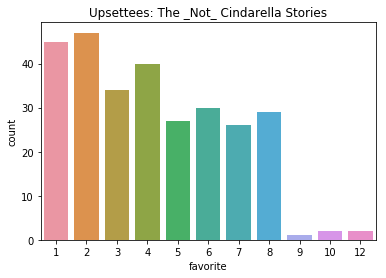

In [176]:
upsetters = data.query('upset == 1')[['favorite', 'Round']]
sn.countplot(x=upsetters['favorite']).set_title('Upsettees: The _Not_ Cindarella Stories')

Takeaway #4: 2 Seeds are upset most often, followed closely by 1 seeds. Interestingly, 4 seeds are upset more often than 3 seeds.
One thing to note is that 8 seeds are upset MUCH more often than 9 seeds, which is noteable given that there are four 8 v 9 
matchups per tournament. We'll dig into whether 8 seeds are being upset by 9's in the first round, or if the bulk of these
upsets occur later in the tournament against even worse seeded teams.

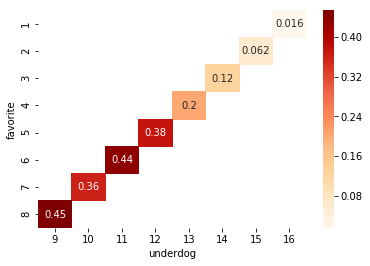

In [212]:
# Let's focus on Round 1
favs = [1, 2, 3, 4, 5, 6, 7, 8]
underdogs = [16, 15, 14, 13, 12, 11, 10, 9]
upset_rate = []
occurences = []
round1 = data.query('Round == 1')
for i in range(1,9):
    matchups = round1[round1['favorite'] == i].shape[0]
    upsets = round1[round1['favorite'] == i][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))

round1_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

upsets = round1_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(upsets, annot=True,cmap = 'OrRd')

Round 1 Takeaway: 13 seeds displace a 4 seed 20% of the time. Given that there are 4 of these matchups in the first round of
every tournament, it might be worth picking an upset. Hindsight is 20/20, but in 2019 UC Irvine pulled off this exact [feat](https://www.cbsnews.com/news/march-madness-2019-uc-irvine-upsets-kansas-state-today-ncaa-tournament-final-score-70-64/)
Sports analysts were shocked, but honestly given the distribution of upsets in round 1 we should almost expect to see one of these
every year. We can see also that 12 seeds upset 5 seeds 38% of the time, so pick one or two of these upsets next time you fill
out a bracket. 11 seeds beat 6 seeds 44% of the time, so definitely worth packing 1 or 2 of these upsets as well.

In [207]:
# Define a function to generate a heatmap-able-data framef

def generate_heatmap(round_n):
    roundn = data[data['Round'] == round_n]

    favorites = list(set(roundn['favorite']))
    favs = []
    underdogs = []

    for fav in favorites:
        dogs = list(set(roundn[roundn['favorite'] == fav]['underdog']))
        favs.extend(repeat(fav, len(dogs)))
        underdogs.extend(dogs)



    upset_rate = []
    occurences = []
    for i in range(0, len(favs)):
    
        matchups = roundn[(roundn.favorite == favs[i]) & (roundn.underdog == underdogs[i])].shape[0]
        upsets = roundn[(roundn.favorite == favs[i]) & (roundn.underdog == underdogs[i])][['upset']].agg('sum')
        upset_rate.append(float(upsets/matchups))
        occurences.append(float(matchups))


    
    round_upsets = pd.DataFrame(
        {'favorite': favs,
         'underdog': underdogs,
         'upset_rate': upset_rate,
         'occurences': occurences
        })

    return round_upsets

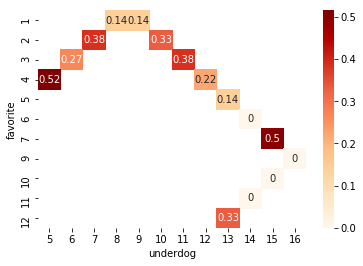

In [211]:
round2_upsets = generate_heatmap(2)
heat = round2_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,cmap = 'OrRd')

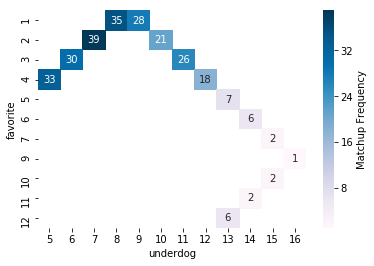

In [209]:
heat = round2_upsets.pivot("favorite", "underdog", "occurences")
ax = sn.heatmap(heat, annot=True, cbar_kws={'label': 'Matchup Frequency'}, cmap="PuBu")

Round 2 Takeaway: The matchup frequency heatmap (purple) is showing us which matchup combinations are common and which are rare. (black).
We can also see from the upset rate heatmap (orange) which upsets are the most _likely_. Combining likelihood and frequency,
we can see that 5's are slightly more likely to over take 4 seeds in round 2. Notice also that 3 seeds are upset by 11 seeds
_more_ often than they are upset by 6 seeds! (3-seeds fall to 11's 38% of the time, and they fall to 6's only 27% of the time).
That's a pretty big difference, especially since 3's face 6 and 11's about equally often.

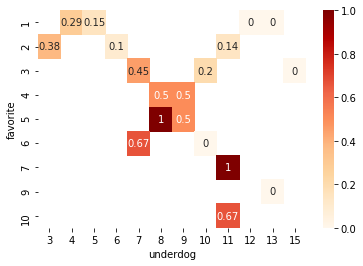

In [201]:
# What about round 3?
round3_upsets = generate_heatmap(3)
heat = round3_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,cmap = 'OrRd')

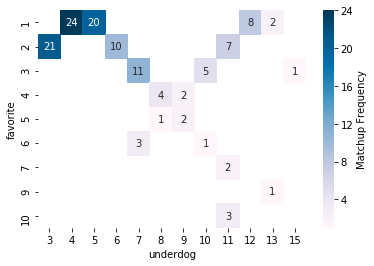

In [202]:
heat = round3_upsets.pivot("favorite", "underdog", "occurences")
ax = sn.heatmap(heat, annot=True, cbar_kws={'label': 'Matchup Frequency'}, cmap="PuBu")

Round 3 Takeaway: We're starting to see some data paucity problems in this realm, as our sample size quickly pares down.
There are only about 5 or 6 matchups that can tell us anything here (the darkest squares on the purple plot). One thing that jumps out 
at me here is the 3 v 7 matchup -- 7 seeds advance to the Elite Eight 45% of the time. So if you happen to come across this
combination in your bracket, it might not be a bad idea to pick 7 over 3. Most of your peers will likely be fooled by the 
disparity in seed ranking and blindly choose the 3 seed over the 7. But the data doesn't lie, 7's are surprisingly successful here.
Also worth noting is that about 1 out of 4 times a 4 seed defeats a 1 seed. The coincidental symmetry there is pleasing, is it not? Let's get
into the elite eight and see what we can find.

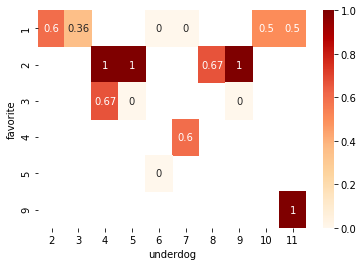

In [203]:
# What about round 4?
round4_upsets = generate_heatmap(4)
heat = round4_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,cmap = 'OrRd')

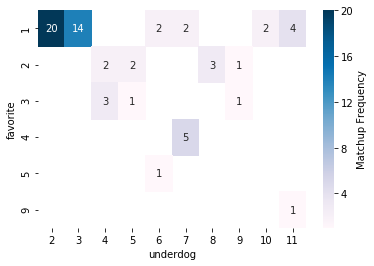

In [197]:
heat = round4_upsets.pivot("favorite", "underdog", "occurences")
ax = sn.heatmap(heat, annot=True, cbar_kws={'label': 'Matchup Frequency'}, cmap="PuBu")

The first thing that jumped out at me here at the 1 seeds that lost to 11 and 10 seeds in the elite eight. That is crazy!
Before I did anything else I had to see who played in those games.

In [184]:
round4.query('seed_1 == 1 & (seed_2 == 11 | seed_2 == 10)')

,Year,Round,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed,favorite,underdog,upset
1381,2006,4,1,84,Connecticut,George Mason,86,11,11,1,11,1
1506,2008,4,1,59,Kansas,Davidson,57,10,1,1,10,0
1696,2011,4,1,61,Kansas,VCU,71,11,11,1,11,1
1883,2014,4,1,62,Florida,Dayton,52,11,1,1,11,0
2012,2016,4,1,62,Virginia,Syracuse,68,10,10,1,10,1
2073,2017,4,1,83,Gonzaga,Xavier,59,11,1,1,11,0


Looks like Syracurse toppled Virginia in 2016 (man the Cavaliers have had it [rough from lowly seeded teams](https://en.wikipedia.org/wiki/2018_UMBC_vs._Virginia_men%27s_basketball_game)),
VCU toppled Kansas in 2011, and George Mason bested UCONN in 2006. Now you can impress your friends with all these forgotten
NCAA facts. Ok on to more analysis.

Recall that the elite eight is the magic round with over 50% of upset candidates resulting in actual upsets. In our 
preliminary EDA we found that each round held roughly a 25% average upset rate _except for the elite eight_, which saw a wild 
jump with over 50% of games resulting in actual upsets.

I was really curious to see what story
the data would tell us here. Interestingly, nearly half of the total upsets happened from 2 seeds taking down 1 seeds. Very interesting! Also
interesting to see that 3 seeds have taken down 1 seeds in 5 out of 14 matchups. It seemed to me that perhaps 1 seeds were 
falling hard in this round, maybe too much pressure or too much ego? It could also be the case that from the graphs it seems
that 1 seeds were being upset more likely just by virtue of the fact that 1 seeds are more likely to make it that far.
A simple way to check whether the _rate_ of being upset is different across seeds in this round would just be to sum the 
upsets by favorite and sum the occurences _(or opportunities to be upset)_ by favorite and look at the upset 
percentage _by seed_ in the elite eight. The null hypothesis being that there is no statistically significant
difference between upset rates across seeds.

In [185]:
round4_upsets['upset_count'] = round4_upsets['occurences']*round4_upsets['upset_rate']
seed_vulnerability = round4_upsets[['favorite', 'occurences', 'upset_count']].groupby(['favorite']).agg('sum')
seed_vulnerability
seed_vulnerability['vulnerability'] = seed_vulnerability['upset_count']/seed_vulnerability['occurences']
seed_vulnerability

,occurences,upset_count,vulnerability
favorite,,,
1,44.0,20.0,0.454545
2,8.0,7.0,0.875000
3,5.0,2.0,0.400000
4,5.0,3.0,0.600000
5,1.0,0.0,0.000000
9,1.0,1.0,1.000000


Elite Eight Takeaway: Wow -- 2 seeds _struggle_ in this round. When favored to win over a worse-seeded opponent in the elite
eight, 2 seeds fall _87.5%_ of the time. That is wild! Granted we only have 8 data points to look at but still. 1 seeds
also struggle here, with about half of 1 seeds who make it to the elite eight surviving to the final four. We don't have
quite enough data points to make any conclusions about lower seeds. What about the final four and the finals you say? Well if I gave away all of my secrets, I'd put myself out of business wouldn't I?
Hopefully this walkthrough helped you learn some new things about seed matchups in the NCAA tournament. If not, well I applaud
you for making it this far and I thank you for taking the time out of your day to read through my work. As a lifelong consumer
of data science blog posts, I have to say I have a renewed respect for those who take the time to publish tutorials like this
on a regular basis. Feel free to send a comment if you have questions/requests/or would like to connect!

Happy madness-ing.

~jane